# The dataset for regression
The dataset required for survival regression must be in the format of a Pandas DataFrame. Each row of the DataFrame represents an observation. There should be a column denoting the durations of the observations. There may (or may not) be a column denoting the event status of each observation (1 if event occurred, 0 if censored). There are also the additional covariates you wish to regress against. Optionally, there could be columns in the DataFrame that are used for stratification, weights, and clusters which will be discussed later in this tutorial.

In [1]:
from lifelines.datasets import load_rossi
rossi = load_rossi()
rossi

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3
...,...,...,...,...,...,...,...,...,...
427,52,0,1,31,0,1,0,1,3
428,52,0,0,20,1,0,0,1,1
429,52,0,1,20,1,1,1,1,1
430,52,0,0,29,1,1,0,1,3


# Fitting the regression
Taking a look at these coefficients for a moment, prio (the number of prior arrests) has a coefficient of about 0.09. Thus, a one unit increase in prio means the the baseline hazard will increase by a factor of exp(0.09)=1.10 - about a 10% increase. 

In [2]:
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi
rossi = load_rossi()

cph = CoxPHFitter()
cph.fit(rossi, duration_col='week', event_col='arrest')

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -658.75
         time fit was run = 2021-01-22 03:26:27 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
fin        -0.38       0.68       0.19            -0.75            -0.00                 0.47                 1.00
age        -0.06       0.94       0.02            -0.10            -0.01                 0.90                 0.99
race        0.31       1.37       0.31            -0.29             0.92                 0.75                 2.50
wexp       -0.15       0.86       0.21            -0.57             0.27                 0.57                 1.30
mar        -0.43       0.65       0.38            -1.18             0.31                 0.31                 1.37
paro       -0.08       0.92       0.20            -0.47             0.30                 0.63                 1.35
prio        0.09       1.10       0.03             0.04             0.15                 1.04                 1.16

              z      p   -log2(p)
covariate                        
fin       -1.98   0.05       4.40
age       -2.61   0.01       6.79
race       1.02   0.31       1.70
wexp      -0.71   0.48       1.06
mar       -1.14   0.26       1.97
paro      -0.43   0.66       0.59
prio       3.19 <0.005       9.48
---
Concordance = 0.64
Partial AIC = 1331.50
log-likelihood ratio test = 33.27 on 7 df
-log2(p) of ll-ratio test = 15.37

In [5]:
import pandas as pd
col_2 = [
    cph._n_examples,
    sum(cph.event_observed),
    cph.baseline_estimation_method,
    cph.event_col,
    cph.duration_col,
    cph._class_name,
    cph.log_likelihood_,
    cph._concordance_index_,
    cph.AIC_partial_]

col_1 = [
    'observations',
    'events_oberved',
    'baseline estimation',
    'event column',
    'duration column',
    'model',
    'log likelihood',
    'concordance',
    'partial AIC'
    
]

results = pd.DataFrame([col_1,col_2]).T
results.columns = ['', ' ']
results.set_index('')

,
,
observations,432
events_oberved,114
baseline estimation,breslow
event column,arrest
duration column,week
model,CoxPHFitter
log likelihood,-658.747659
concordance,0.640329
partial AIC,1331.495319


# Plotting the coefficients
After fitting, we can plot what the survival curves look like as we vary a single covariate while holding everything else equal. This is useful to understand the impact of a covariate, given the model. To do this, we use the plot_partial_effects_on_outcome() method and give it the covariate of interest, and the values to display.

matplotlib.axes._subplots.AxesSubplot

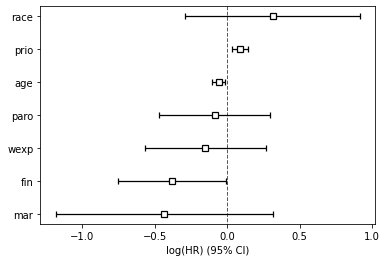

In [18]:
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter

rossi = load_rossi()
cph = CoxPHFitter()
cph.fit(rossi, duration_col='week', event_col='arrest')

type(cph.plot())

# Plotting the effect of varying a covariate

After fitting, we can plot what the survival curves look like as we vary a single covariate while holding everything else equal. This is useful to understand the impact of a covariate, given the model. To do this, we use the plot_partial_effects_on_outcome() method and give it the covariate of interest, and the values to display.

<AxesSubplot:>

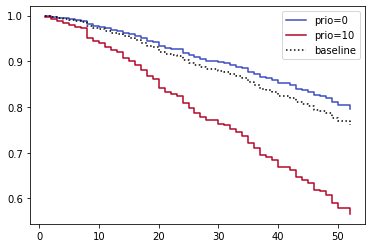

In [19]:
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter

rossi = load_rossi()
cph = CoxPHFitter()
cph.fit(rossi, duration_col='week', event_col='arrest')

cph.plot_partial_effects_on_outcome(covariates='prio', values=[0, 10], cmap='coolwarm')

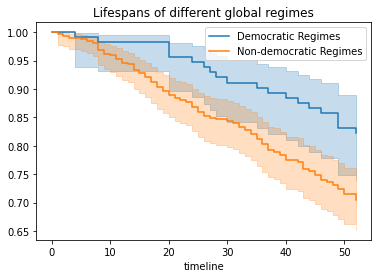

In [24]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

ax = plt.subplot(111)

df = rossi
dem = (df["prio"] == 1)

T = rossi["week"]
E = rossi["arrest"]

kmf.fit(T, event_observed=E)

kmf.fit(T[dem], event_observed=E[dem], label="Democratic Regimes")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[~dem], event_observed=E[~dem], label="Non-democratic Regimes")
kmf.plot_survival_function(ax=ax)

plt.title("Lifespans of different global regimes");

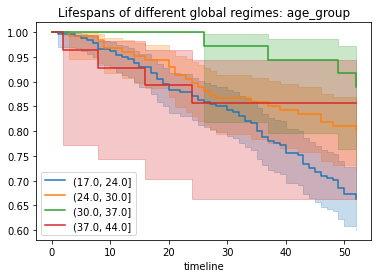

In [25]:
import pandas as pd
from pandas import CategoricalDtype


DURATION = 'week'
EVENT = 'arrest'
features = [x for x in df.columns if x not in [DURATION, EVENT]]

# Feature Engineering
df = rossi
df['age_group'] = pd.cut(df['age'], bins=4, precision=0)
df['priors_group'] = pd.cut(df['prio'], bins=4, precision=0)
num_cols = ['age', 'prio']


def plotter(df, option, DURATION, EVENT, num_cols, CategoricalDtype):
    ax = plt.subplot(111)
    T = df[DURATION]
    E = df[EVENT]

    if isinstance(df[option].dtype, CategoricalDtype):
        unique_codes = list(set(df[option].cat.codes.values))
        unique_codes.sort()

        mapping = dict(zip(
            df[option].cat.codes.values,
            df[option].values))
        kmf.fit(T, E)

        for code in unique_codes:
            subset = (df[option] == mapping[code])
            kmf.fit(T[subset], event_observed=E[subset], label=mapping[code])
            kmf.plot_survival_function(ax=ax)
            
    else:
        unique_codes = list(set(df[option].values))
        unique_codes.sort()
        
        kmf.fit(T, E)

        for code in unique_codes:
            subset = (df[option] == code)
            kmf.fit(T[subset], event_observed=E[subset], label=code)
            kmf.plot_survival_function(ax=ax)
                



    plt.title("Lifespans of different global regimes: " + option)
    return plt


option = 'age_group'
plt = plotter(df, option, DURATION, EVENT, num_cols, CategoricalDtype)
#plt
#print(unique_values)

# Churn Prediction
https://towardsdatascience.com/churn-prediction-and-prevention-in-python-2d454e5fd9a5

The point of this exercise was to get some usable information to help us make decisions about how to intervene to reduce and prevent churn. So let’s make some predictions. Unfortunately, there’s not much we can do for the customers who have already left, so let’s select only the remaining customers from our dataset:

In Survival Analysis lingo, a censored observation is one which is yet to have an ‘event’, so we’re selecting all those customer who have yet to churn. Now to predict their survival curves we use the handy method .predict_survival_function like so:

In [45]:
censored_subjects = rossi.loc[df[EVENT] == 0]
censored_subjects
unconditioned_sf = cph.predict_survival_function(censored_subjects)
conditioned_sf = unconditioned_sf.apply(lambda c: (c / c.loc[data.loc[c.name, DURATION]]).clip(1))
#subject = 12.0
#unconditioned_sf[subject].plot(ls="--", color="#A60628", label="unconditioned") 
#conditioned_sf[subject].plot(color="#A60628", label="conditioned on $T>58$")
#plt.legend()
conditioned_sf.iloc[1,:]

3      1.140997
4      1.388653
5      1.397934
7      1.350405
8      1.876495
         ...   
427    1.119375
428    1.507521
429    1.169652
430    1.287937
431    1.211864
Name: 2.0, Length: 318, dtype: float64

ICI =  0.010120653490331425
E50 =  0.009578795407702012


,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3
...,...,...,...,...,...,...,...,...,...
427,52,0,1,31,0,1,0,1,3
428,52,0,0,20,1,0,0,1,1
429,52,0,1,20,1,1,1,1,1
430,52,0,0,29,1,1,0,1,3


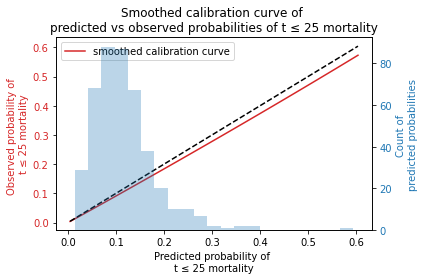

In [108]:
from lifelines import CoxPHFitter, WeibullAFTFitter
from lifelines.datasets import load_rossi
from lifelines.calibration import survival_probability_calibration


rossi = load_rossi()
cph = CoxPHFitter()#baseline_estimation_method="spline", n_baseline_knots=3)
cph.fit(rossi, "week", "arrest")
survival_probability_calibration(cph, rossi, t0=25)

In [133]:
# all regression models can be used here, WeibullAFTFitter is used for illustration
wf = WeibullAFTFitter().fit(rossi, "week", "arrest")

# filter down to just censored subjects to predict remaining survival
censored_subjects = rossi.loc[~rossi['arrest'].astype(bool)]
censored_subjects_last_obs = censored_subjects['week']

# predict new survival function
wf.predict_survival_function(censored_subjects, conditional_after=censored_subjects_last_obs)

# predict median remaining life
wf.predict_median(censored_subjects.iloc[:1,:], conditional_after=censored_subjects_last_obs)

censored_subjects.iloc[:1,:]

,week,arrest,fin,age,race,wexp,mar,paro,prio
3,52,0,1,23,1,1,1,1,1


In [143]:
wf = WeibullAFTFitter().fit(rossi, "week", "arrest")
predict_input = pd.DataFrame([52, 0, 1, 23, 1, 1, 1, 1, 1]).T
predict_input.columns = ['week', 'arrest', 'fin', 'age', 'race', 'wexp', 'mar', 'paro', 'prio']
wf.predict_median(predict_input, conditional_after=predict_input[DURATION])

0    138.430667
dtype: float64

In [151]:
[*set(rossi['arrest'].values)]

[0, 1]